# Successive Halving with sklearn

In this notebook, we'll optimize hyperparameters using successive halving from sklearn.

Sklearn has 2 classes for successive halving:

- [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html)
- [HalvingGridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html)

The difference is how they create the hyperparameter combinations that will be tested. The first samples hyperparameters at random from provided distributions. The second creates the hyperparameter combinations based on the provided grid.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv

# now you can import normally from model_selection
from sklearn.model_selection import HalvingRandomSearchCV

In [2]:
# load dataset

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
y = y.map({0:1, 1:0})

X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=0)

X_train.shape, X_test.shape

((512, 30), (57, 30))

## Successive halving

In [4]:
# set up the model

gbm = GradientBoostingClassifier(random_state=0)

In [5]:
# determine the hyperparameter space

param_grid = dict(
    n_estimators=stats.randint(10, 120),
    min_samples_split=stats.uniform(0, 1),
    max_depth=stats.randint(1, 5),
    loss=('log_loss', 'exponential'),
)

In [6]:
# set up the search
search = HalvingRandomSearchCV(
    estimator=gbm,
    param_distributions=param_grid,
    n_candidates="exhaust",
    factor=3,                  # only a third of the candidates are promoted
    resource='n_samples',      # the limiting resource
    max_resources="auto",
    min_resources="smallest",
    scoring='roc_auc',
    cv=3,
    random_state=10,
    refit=True,
)

# find best hyperparameters
search.fit(X_train, y_train)

HalvingRandomSearchCV(cv=3,
                      estimator=GradientBoostingClassifier(random_state=0),
                      param_distributions={'loss': ('log_loss', 'exponential'),
                                           'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BDF2C67CA0>,
                                           'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001BDF2C66EC0>,
                                           'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BDF2C67400>},
                      random_state=10, scoring='roc_auc')

In [7]:
# best performance

search.best_score_

0.9872357020531565

In [8]:
# the best hyperparameters are stored in an attribute

search.best_params_

{'loss': 'log_loss',
 'max_depth': 2,
 'min_samples_split': 0.6010389534045444,
 'n_estimators': 33}

In [9]:
# we also find the data for all models evaluated

results = pd.DataFrame(search.cv_results_)
results.head()

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_max_depth,param_min_samples_split,param_n_estimators,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,12,0.088111,0.013189,0.006000,2.946137e-03,exponential,2,0.020752,74,...,0.75,1.0,0.916667,0.117851,23,1.0,1.0,1.0,1.0,0.0
1,0,12,0.085285,0.000456,0.004330,4.701903e-04,exponential,4,0.831911,103,...,0.75,1.0,0.916667,0.117851,23,1.0,1.0,1.0,1.0,0.0
2,0,12,0.016990,0.000833,0.003331,4.712020e-04,log_loss,2,0.198063,18,...,0.75,1.0,0.916667,0.117851,23,1.0,1.0,1.0,1.0,0.0
3,0,12,0.040643,0.003087,0.003998,3.371748e-07,exponential,1,0.263603,46,...,0.75,1.0,0.916667,0.117851,23,1.0,1.0,1.0,1.0,0.0
4,0,12,0.020655,0.001698,0.003664,4.709771e-04,exponential,1,0.816602,21,...,0.75,1.0,0.916667,0.117851,23,1.0,1.0,1.0,1.0,0.0


In [10]:
# the number of models / hyperparam combinations 
# tested at each round

results.groupby("iter")["n_resources"].count()

iter
0    42
1    14
2     5
3     2
Name: n_resources, dtype: int64

In [11]:
# the number observations used to train the model at each round

results.groupby("iter")["n_resources"].mean()

iter
0     12.0
1     36.0
2    108.0
3    324.0
Name: n_resources, dtype: float64

In [12]:
X_train.shape

(512, 30)

In [13]:
# the average time taken to fit models at each round

results.groupby("iter")[["mean_fit_time", "std_fit_time"]].mean()

,mean_fit_time,std_fit_time
iter,,
0,0.108078,0.016665
1,0.072615,0.007214
2,0.171313,0.034776
3,0.224704,0.032387


In [14]:
# the best model performance at each round

results.groupby("iter")["mean_test_score"].max()

iter
0    0.958333
1    0.980952
2    0.980893
3    0.987236
Name: mean_test_score, dtype: float64

In [15]:
# Winner models are evaluated further
results["params_str"] = results.params.apply(str)

results.groupby(["params_str"])["iter"].count().sort_values()

params_str
{'loss': 'exponential', 'max_depth': 1, 'min_samples_split': 0.26360284602895234, 'n_estimators': 46}    1
{'loss': 'log_loss', 'max_depth': 1, 'min_samples_split': 0.5954396049995773, 'n_estimators': 72}        1
{'loss': 'log_loss', 'max_depth': 4, 'min_samples_split': 0.5655070198881675, 'n_estimators': 92}        1
{'loss': 'log_loss', 'max_depth': 1, 'min_samples_split': 0.8126209616521135, 'n_estimators': 72}        1
{'loss': 'log_loss', 'max_depth': 1, 'min_samples_split': 0.8723924598391091, 'n_estimators': 114}       1
{'loss': 'log_loss', 'max_depth': 2, 'min_samples_split': 0.04309735620499444, 'n_estimators': 115}      1
{'loss': 'log_loss', 'max_depth': 2, 'min_samples_split': 0.19806286475962398, 'n_estimators': 18}       1
{'loss': 'log_loss', 'max_depth': 3, 'min_samples_split': 0.1712385982079181, 'n_estimators': 117}       1
{'loss': 'log_loss', 'max_depth': 2, 'min_samples_split': 0.22487280246981334, 'n_estimators': 58}       1
{'loss': 'log_loss', 'max_

The last one is the winner

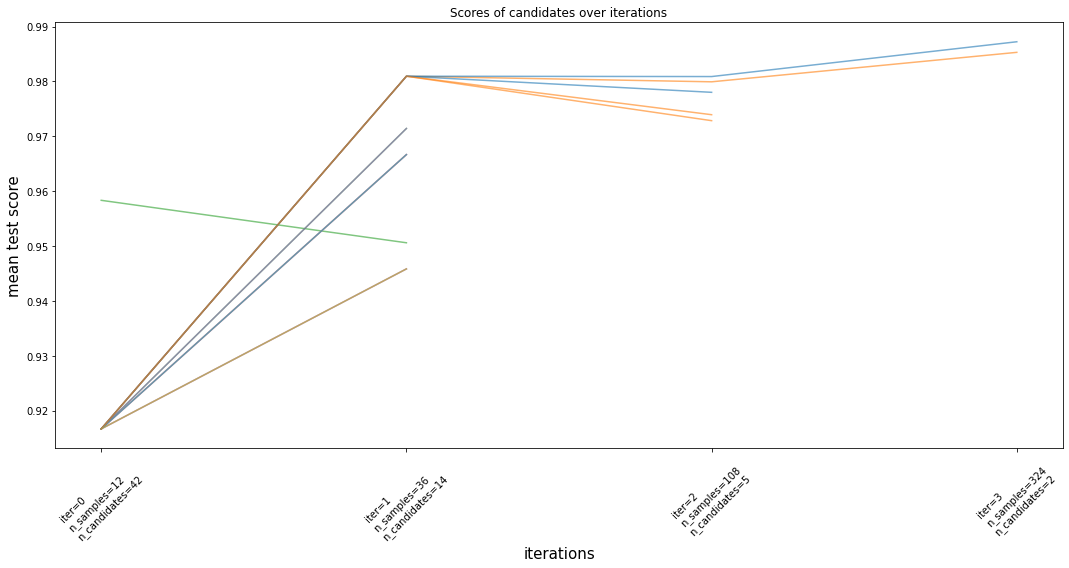

In [16]:
# taken from sklearn:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_iterations.html

# prepare data
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)

# plot
ax = mean_scores.plot(legend=False, alpha=0.6, figsize=(15,8))

labels = [
    f"iter={i}\nn_samples={search.n_resources_[i]}\nn_candidates={search.n_candidates_[i]}"
    for i in range(search.n_iterations_)
]

ax.set_xticks(range(search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

## Final model evaluation

In [17]:
X_train_preds = search.predict_proba(X_train)[:,1]
X_test_preds = search.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

Train roc_auc:  0.9969679633867277
Test roc_auc:  0.9941558441558441


## Optimizing the search

We can explore more configurations at lower budget by changing the value of `min_resources`.

In [18]:
# set up the search
search = HalvingRandomSearchCV(
    estimator=gbm,
    param_distributions=param_grid,
    n_candidates="exhaust",
    factor=2,                  # only half of the candidates are promoted
    resource='n_samples',      # the limiting resource
    max_resources="auto",
    min_resources=24,
    scoring='roc_auc',
    cv=3,
    random_state=10,
    refit=True,
)

# find best hyperparameters
search.fit(X_train, y_train)

# best performance
search.best_score_

0.9881878389019564

By reducing the number of minimum resources, usually at the first iteration, we can explore more hyperparameter combinations. Here, we explore 21 combinations using 24 samples as training data.

In [19]:
results = pd.DataFrame(search.cv_results_)
results.groupby("iter")["n_resources"].agg(['mean', "count"])

,mean,count
iter,,
0,24.0,21
1,48.0,11
2,96.0,6
3,192.0,3
4,384.0,2


In [20]:
# set up the search
search = HalvingRandomSearchCV(
    estimator=gbm,
    param_distributions=param_grid,
    n_candidates="exhaust",
    factor=2,                  # only half of the candidates are promoted
    resource='n_samples',      # the limiting resource
    max_resources="auto",
    min_resources=48,
    scoring='roc_auc',
    cv=3,
    random_state=10,
    refit=True,
)

# find best hyperparameters
search.fit(X_train, y_train)

# best performance
search.best_score_

0.9825705720286564

By increasing the number of minimum resources, we explore less hyperparameter combinations, but we can trust their output more. Here we explore only 10 hyperparameter combinations, training the models on 48 samples.

In [21]:
results = pd.DataFrame(search.cv_results_)
results.groupby("iter")["n_resources"].agg(['mean', "count"])

,mean,count
iter,,
0,48.0,10
1,96.0,5
2,192.0,3
3,384.0,2


Note that in none of the cases, we use the entire dataset. This is because we reached the maximum allowed budget: if we doubled 384, we exceed 512 that is the size of our current train set.

If we want to use 512 at the last iteration, we need to think backwards.

In [22]:
512/16

32.0

In [23]:
# set up the search
search = HalvingRandomSearchCV(
    estimator=gbm,
    param_distributions=param_grid,
    n_candidates="exhaust",
    factor=2,                  # only half of the candidates are promoted
    resource='n_samples',      # the limiting resource
    max_resources=512,
    min_resources=32,
    scoring='roc_auc',
    cv=3,
    random_state=10,
    refit=True,
)

# find best hyperparameters
search.fit(X_train, y_train)

# best performance
search.best_score_

0.9914336370533366

In [24]:
results = pd.DataFrame(search.cv_results_)
results.groupby("iter")["n_resources"].agg(['mean', "count"])

,mean,count
iter,,
0,32.0,16
1,64.0,8
2,128.0,4
3,256.0,2
4,512.0,1


This is a very simple dataset and a very simple model. With more data and more complex models, choosing these parameters wisely becomes more relevant.